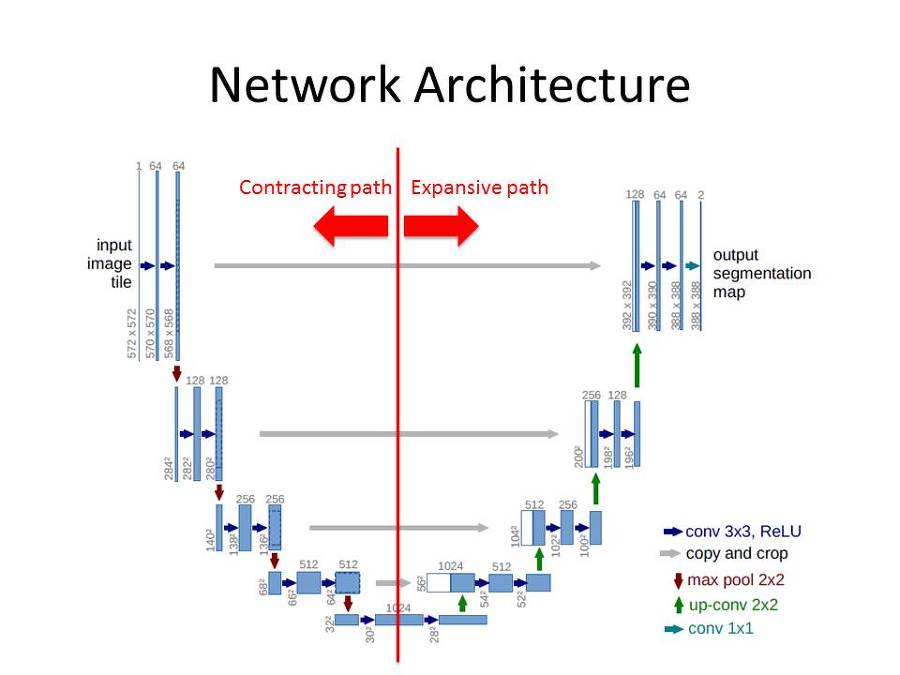

U-Nets are FCN(Fully Convolution Networks), which dont have anything but convolution layer. U-nets take input image and output some image. U-net used for Segmentation take input image and outputs segmentation mask, no labels needed. Loss used is DICE loss(dice coefficient) which is essentially a measure of overlap between two samples. This measure ranges from 0 to 1 where a Dice coefficient of 1 denotes perfect and complete overlap.

[Here's](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjDo7bH_prvAhXDzDgGHYJhDsAQFjAAegQIAxAD&url=https%3A%2F%2Fmedium.com%2Fswlh%2Fresnets-densenets-unets-6bbdbcfdf010&usg=AOvVaw36Ndu_QuQ4bZzzN2efV8A-) some more explaination on U-Nets architecture.

In [1]:
import os, random, cv2, shutil
import numpy as np
import torch, torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
from collections import defaultdict
from torchvision import models
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (15,8)

seed = 2048
def seed_torch(seed=2021):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed)

In [ ]:
print(torch.cuda.get_device_name(0)) 

Tesla T4


## Download and show data

In [2]:
# copy dataset from drive

a = '/content/cleaned-oxford-pets-dataset.tar.gz'
b = '/content/drive/MyDrive/Datasets/cleaned-oxford-pets-dataset.tar.gz'

shutil.copyfile(b,a)

!tar -xzf /content/cleaned-oxford-pets-dataset.tar.gz
!rm -rf /content/content/cleaned-oxford-pets-dataset/images/Egyptian_Mau_129.jpg

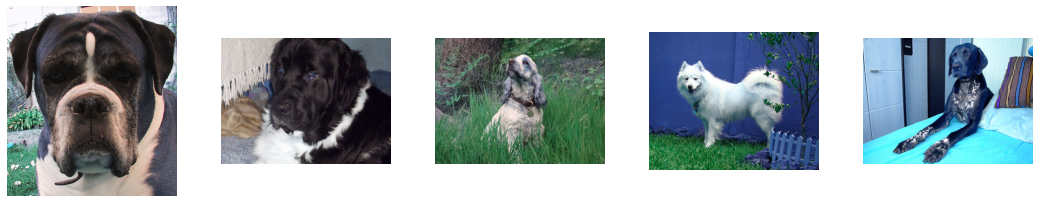

In [146]:
image_ids = [a[:-4] for a in os.listdir("/content/content/cleaned-oxford-pets-dataset/images")[:5]]

r,c = 1,5
f, axs = plt.subplots(r,c)
f.tight_layout()
a= 0
p = '/content/content/cleaned-oxford-pets-dataset/images/'

for i in range(r):
  for j in range(c):
    im = cv2.imread(p+image_ids[a]+'.jpg')
    axs[j].imshow(im)
    axs[j].axis('off')
    a+=1

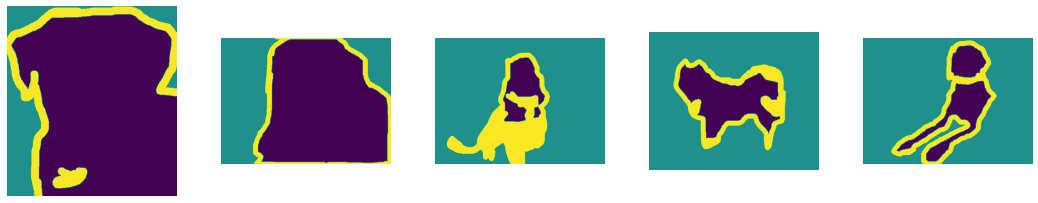

In [147]:
# masks sample

r,c = 1,5
f, axs = plt.subplots(r,c)
f.tight_layout()
a= 0
p = '/content/content/cleaned-oxford-pets-dataset/trimaps/'

for i in range(r):
  for j in range(c):
    mask = cv2.imread(p+image_ids[a]+'.png', cv2.IMREAD_GRAYSCALE)
    axs[j].imshow(np.array(mask) / 2 * 255 )
    axs[j].axis('off')
    a+=1

# DataLoader

In [57]:
# create dataset

class PetsDataset(Dataset):

  def __init__(self, image_ids, transform=None):
    self.image_ids = image_ids # imgs are jpg, masks are png
    self.transform = transform
    self.image_size = [224,224]

  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, index):
    image_id = self.image_ids[index]
    image = cv2.imread("/content/content/cleaned-oxford-pets-dataset/images/" + image_id +'.jpg', cv2.COLOR_BGR2RGB)

    mask = cv2.imread("/content/content/cleaned-oxford-pets-dataset/trimaps/"+ image_id +'.png', cv2.IMREAD_UNCHANGED)
    mask = cv2.resize(mask, (self.image_size[0], self.image_size[1]), interpolation = cv2.INTER_NEAREST)

    # in this trimaps 1 "pet", 2 "background", 3 "border", so we make 1,3 = 1 and 2=0 (background)
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0
    mask = torch.as_tensor(mask, dtype=torch.uint8)
    mask = mask.reshape(1, 224, 224)
    image = self.transform(image)

    return image, mask

In [133]:
batch_size = 64

image_ids = [a[:-4] for a in os.listdir("/content/content/cleaned-oxford-pets-dataset/images")]
x_train, x_val = train_test_split(image_ids, test_size=0.2, random_state=seed)

transform = transforms.Compose([
    transforms.ToTensor(),
    torchvision.transforms.Resize([224, 224]),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = PetsDataset(x_train, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = PetsDataset(x_val, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print('Train Dataset {} and Test Dataset {}'.format(len(train_dataset), len(val_dataset)))

Train Dataset 2803 and Test Dataset 701


In [92]:
# test output
val_dataset[0][0].shape, val_dataset[0][1].shape

(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

## Model

In [134]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [135]:
def dice_loss(prediction, target):
  """Calculating the dice loss
  Args:
      prediction = predicted image
      target = Targeted image
  Output:
      dice_loss"""
  smooth = 1.0
  i_flat = prediction.view(-1)
  t_flat = target.view(-1)
  intersection = (i_flat * t_flat).sum()
  return 1 - ((2. * intersection + smooth) / (i_flat.sum() + t_flat.sum() + smooth))

def calc_loss(prediction, target, bce_weight=0.5):
  """Calculating the loss and metrics
  Args:
      prediction = predicted image
      target = Targeted image
      metrics = Metrics printed
      bce_weight = 0.5 (default)
  Output:
      loss : dice loss of the epoch """
  metrics = defaultdict(float)     
  bce = F.binary_cross_entropy_with_logits(prediction, target.type(torch.float))
  prediction = F.sigmoid(prediction)
  dice = dice_loss(prediction, target)

  loss = bce * bce_weight + dice * (1 - bce_weight)
  metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
  metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
  metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
  return loss, metrics

## Training

In [136]:
def train_one_epoch(model, train_loader):
    model.train()
    for images, masks in train_loader:
      images = images.to('cuda')
      masks = masks.to('cuda')
      outputs = model(images)
      loss, losses_dict = calc_loss(outputs, masks)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    return losses_dict

def val_one_epoch(model, val_loader):
    model.eval()
    for images, masks in val_loader:
      images = images.to('cuda')
      masks = masks.to('cuda')
      with torch.no_grad():
        outputs = model(images)
      losses, losses_dict = calc_loss(outputs, masks)

    return losses_dict

In [137]:
epochs = 10
lr = 0.02
MIN_LOSS = 1.0
train_step = len(train_loader)/batch_size
val_step = len(val_loader)/batch_size
TRAIN_LOSSES = []
VAL_LOSSES = []
model_save_path = '/content/pet_finder.bin'

model = ResNetUNet(n_class=1)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=8,gamma=0.1)
model = model.to('cuda')

for epoch in range(1, epochs+1):
  print('Epoch:',epoch)

  loss_dict = train_one_epoch(model, train_loader)
  train_l = loss_dict['loss'] / train_step
  print("Training Loss:", train_l)
  TRAIN_LOSSES.append(train_l)

  loss_dict = val_one_epoch(model, val_loader)
  valid_l = loss_dict['loss'] / val_step
  print("Val Loss:", valid_l)
  VAL_LOSSES.append(valid_l)

  if scheduler is not None:
    scheduler.step()

  if MIN_LOSS > min(VAL_LOSSES):
      MIN_LOSS = min(VAL_LOSSES)
      torch.save({
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict()
                  }, model_save_path)
      print('Model Saved...')

Epoch: 1
Training Loss: 41.91415526650169
Val Loss: 193.46597081964666
Epoch: 2
Training Loss: 17.847667173905805
Val Loss: 98.99811692671342
Epoch: 3
Training Loss: 11.68496385487643
Val Loss: 66.12022278525613
Epoch: 4
Training Loss: 10.292326146906072
Val Loss: 54.889822699806906
Epoch: 5
Training Loss: 9.97065392407504
Val Loss: 50.29059687527743
Epoch: 6
Training Loss: 9.095423535867171
Val Loss: 54.93654181740501
Epoch: 7
Training Loss: 7.90499467199499
Val Loss: 45.82982548800382
Epoch: 8
Training Loss: 6.73054208538749
Val Loss: 46.01134993813255
Epoch: 9
Training Loss: 6.018439292907715
Val Loss: 45.76692338423295
Epoch: 10
Training Loss: 6.860818992961537
Val Loss: 45.53791297565807


Note: The higher loss is due to higher batch_size and lr.

## Show Results

In [138]:
# model.load_state_dict(torch.load('/content/pet_finder.bin')['model_state_dict'])

images = []
predicted_masks = []
for im in x_val[:5]:
  image = cv2.imread("/content/content/cleaned-oxford-pets-dataset/images/" + im +'.jpg', cv2.COLOR_BGR2RGB)
  images.append(image)
  image = transform(image)
  image = image.to('cuda')
  with torch.no_grad():
    outputs = model(image.reshape(1, 3, 224, 224))
  predicted_masks.append(outputs.cpu().numpy().reshape(224, 224)) 

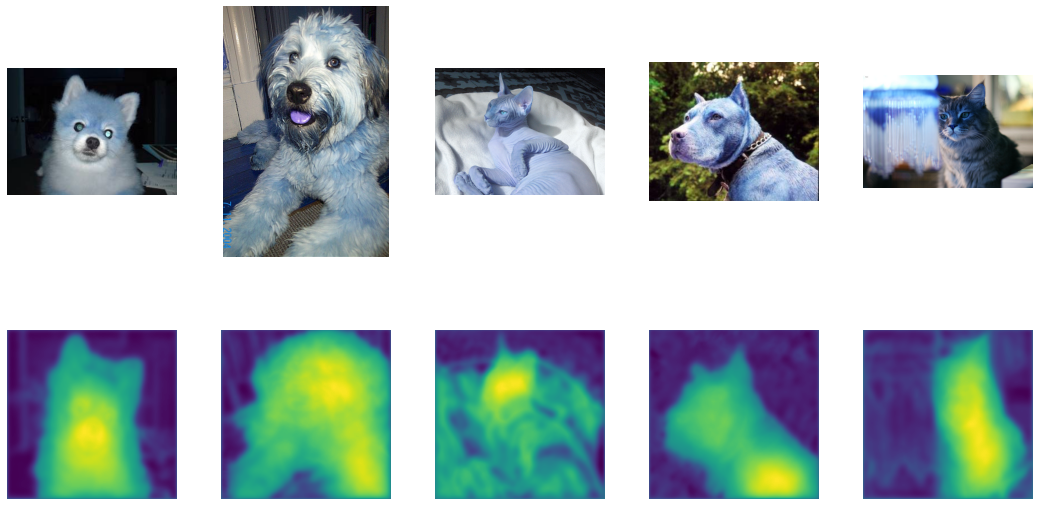

In [139]:
plt.rcParams["figure.figsize"] = (15,8)
r,c = 2,5
f, axs = plt.subplots(r,c)
f.tight_layout()
a= 0
imshows = images+predicted_masks

for i in range(r):
  for j in range(c):
    axs[i,j].imshow(imshows[a])
    axs[i,j].axis('off')
    a+=1

Summary: U-net tend to perform well on Semantic Segmentation task and are cheaper to train, imporvements:
* Tweak architecture.
* More Training.

Reference: 
https://github.com/bigmb/Unet-Segmentation-Pytorch-Nest-of-Unets